### Get data

In [1]:
from boiles.test_cases.shuosher_200 import ShuDisper200, ShuShock200
from boiles.test_cases.tgv import TGV
from boiles.config.opt_problems import OP
from boiles.config.opt_config import OC
from boiles.solvers.solver_config import SC
# OP, OC and SC are Singleton classes. They should be configured at the very beginning of the script
OP.test_cases = [ShuDisper200, ShuShock200, TGV]
OP.ref_point = [ShuDisper200.ref_point, ShuShock200.ref_point, TGV.ref_point]

OC.seed = 1234
OC.training_samples = 30
OC.opt_iterations = 30
OC.dim_inputs = 2
OC.dim_outputs = 3
OC.opt_bounds = [(20, 400), (1, 20)]
OC.fun_bounds = [(1000, 20000), (1, 20)]
OC.increment = (50, 1)
OC.case_folder = 'runtime_data'
OC.debug = False




In [2]:
def unit_cq_q(cq_q):
    cq_unit = (cq_q[:, 0] - OC.opt_bounds[0][0]) / (OC.opt_bounds[0][1] - OC.opt_bounds[0][0])
    q_unit  = (cq_q[:, 1] - OC.opt_bounds[1][0]) / (OC.opt_bounds[1][1] - OC.opt_bounds[1][0])
    return np.vstack((cq_unit, q_unit)).transpose()

def reverse_cq_q(value, name):
    if name == "cq":
        x = value * (OC.opt_bounds[0][1] - OC.opt_bounds[0][0]) + OC.opt_bounds[0][0]
        x *= OC.increment[0]
    if name == "q":
        x = value * (OC.opt_bounds[1][1] - OC.opt_bounds[1][0]) + OC.opt_bounds[1][0]
        x *= OC.increment[1]
    return x.reshape(-1, 1)

def standaardize_y(value):
    mean = value.mean()
    std = value.std()
    return (value - mean) / std

def reverse_y(value, ref):
    mean = np.array(ref.mean())
    std = np.array(ref.std())
    return value * std + mean

In [3]:
from boiles.utils import read_from_csv
import numpy as np
import torch

# just delete the label row of the opt_history and save it as opt_history_post.csv
data = read_from_csv('runtime_data/opt_history_post.csv')

index = data[:, 4].astype(int).reshape(-1, 1)
cq_q = data[:, 6:8].astype(int)
cq_q = unit_cq_q(cq_q)

shu_disper_raw = data[:, 1].reshape(-1, 1).astype(float)
shu_shock_raw = data[:, 2].reshape(-1, 1).astype(float)
tgv_raw = data[:, 3].reshape(-1, 1).astype(float)

shu_disper = standaardize_y(shu_disper_raw)
shu_shock = standaardize_y(shu_shock_raw)
tgv = standaardize_y(tgv_raw)
Yvar = (np.zeros(tgv.shape[0])).reshape(-1, 1)
Yvar = torch.tensor(Yvar, dtype=torch.float)

cq_q = torch.tensor(cq_q, dtype=torch.float)
obj_raw = np.concatenate((shu_disper_raw, shu_shock_raw, tgv_raw), axis=1)
obj = np.concatenate((shu_disper, shu_shock, tgv), axis=1)
obj = torch.tensor(obj, dtype=torch.float)

In [4]:
import matplotlib.ticker as ticker
from ax.models.torch.utils import predict_from_model
import scipy.ndimage
import gpytorch
import matplotlib.pyplot as plt

def plot_contour(model,
                 cq_q=None,
                 title=None,
                 raw_data=False,
                 ref=None,
                 levels=50,
                 label_fontsize=10,
                 tick_fontsize=10,
                 save=True,
                 save_name="gp.jpg",
                 dpi=200):
    n = 100
    cq_test = torch.linspace(0, 1, n).reshape((-1, 1))
    q_test = torch.linspace(0, 1, n).reshape((-1, 1))
    cq_q_test = torch.cat((cq_test, q_test), 1)
    cq_q_test = gpytorch.utils.grid.create_data_from_grid(cq_q_test)

    pred_test, var = predict_from_model(model, cq_q_test)
    pred_test = pred_test.numpy()
    
    q_in_plot = reverse_cq_q(q_test, 'q')
    cq_in_plot = reverse_cq_q(cq_test, 'cq')
    
    x1, x2 = np.meshgrid(q_in_plot, cq_in_plot)
    
    pred_in_plot = reverse_y(pred_test, ref=ref)
#         pred_test = torch.clamp(torch.tensor(pred_test), CC.error_initial_lowest['tgv'], CC.error_upper_bound['tgv']).numpy()
    pred_in_plot = pred_in_plot.reshape((n, n)).transpose()
    fig, ax = plt.subplots(figsize=(6, 5), dpi=dpi)
    con = ax.contourf(x1, x2, pred_in_plot, levels=levels)
    ax.set_xlabel(r'$q$', fontsize=label_fontsize)
    ax.set_ylabel(r'$C_q$', fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    if cq_q is not None:
        ax.scatter(cq_q[:30, 1], cq_q[:30, 0], c='grey', alpha=0.8, edgecolor='none')
        ax.scatter(cq_q[30:, 1], cq_q[30:, 0], c='orange', alpha=0.8, edgecolor='none')
        ax.scatter(9, 15900, c='blue', marker='x')
    if title is not None:
        ax.set_title(title)
    if raw_data:
        ax.yaxis.get_major_formatter().set_powerlimits((3, 3))
    cbar = fig.colorbar(con, ax=ax)
    cbar.ax.tick_params(labelsize=tick_fontsize)
    cbar.formatter.set_powerlimits((-2, 2))
    cbar.update_ticks()
    fig.tight_layout()
    if save:
        plt.savefig(save_name)
#     plt.close(fig)
    return pred_test

In [5]:
models = []

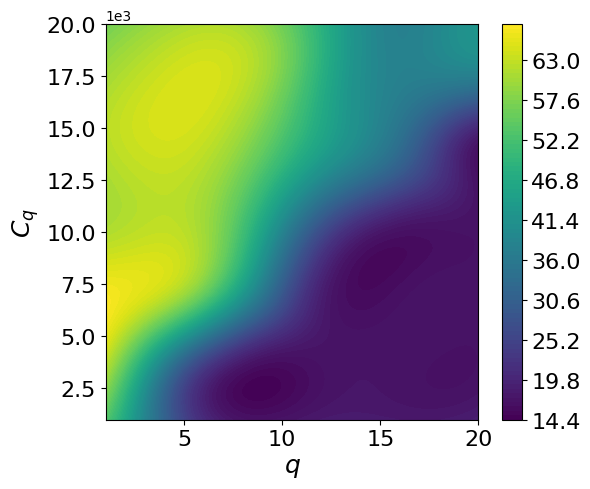

In [6]:
from boiles.models.gp_model import GPModel
from boiles.models.get_model import get_GP
dpi=100

iteration = 30
data_num = iteration+30

save_name = "disper_final.png"
model = get_GP(X=cq_q[:data_num], Y=obj[:data_num, 0].reshape(-1, 1), Yvar=Yvar[:data_num], case=OP.test_cases[0])
state_dict = torch.load(f'runtime_data/model_state/disper_model_state_{iteration}.pth')
model.load_state_dict(state_dict)
plot_contour(model, raw_data=True, ref=shu_disper_raw[:data_num, 0], label_fontsize=18, tick_fontsize=16, save_name=save_name, dpi=dpi, levels=100)
models.append(model)

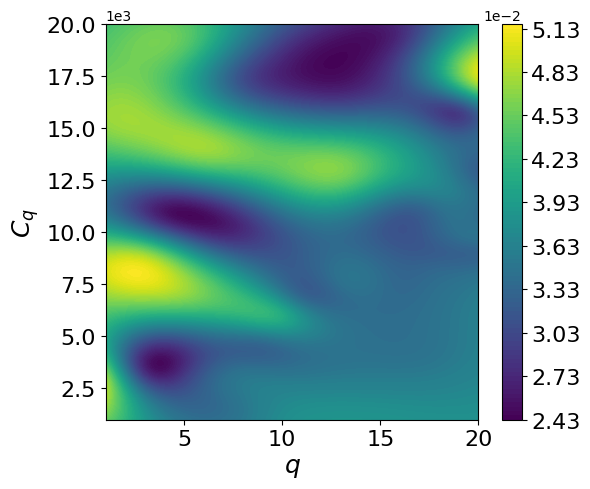

In [7]:
save_name = "shock_final.png"
model = get_GP(X=cq_q[:data_num], Y=obj[:data_num, 1].reshape(-1, 1), Yvar=Yvar[:data_num], case=OP.test_cases[1])
state_dict = torch.load(f'runtime_data/model_state/shock_model_state_{iteration}.pth')
model.load_state_dict(state_dict)
plot_contour(model, raw_data=True, ref=shu_shock_raw[:data_num, 0], label_fontsize=18, tick_fontsize=16, save_name=save_name, dpi=dpi, levels=100)
models.append(model)


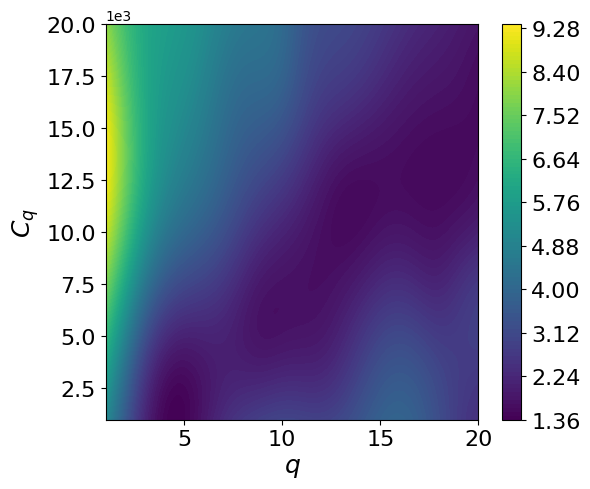

In [8]:
save_name = "tgv_final.png"
model = get_GP(X=cq_q[:data_num], Y=obj[:data_num, 2].reshape(-1, 1), Yvar=Yvar[:data_num], case=OP.test_cases[2])
state_dict = torch.load(f'runtime_data/model_state/tgv_model_state_{iteration}.pth')
model.load_state_dict(state_dict)
plot_contour(model, raw_data=True, ref=tgv_raw[:data_num, 0], label_fontsize=18, tick_fontsize=16, save_name=save_name, dpi=dpi, levels=100)
models.append(model)

## Find CV Optimum

In [9]:
from ax import *
from ax.modelbridge.factory import get_sobol


x1 = RangeParameter(name="cq", lower=OC.opt_bounds[0][0], upper=OC.opt_bounds[0][1], parameter_type=ParameterType.INT)
x2 = RangeParameter(name="q", lower=OC.opt_bounds[1][0], upper=OC.opt_bounds[1][1], parameter_type=ParameterType.INT)

search_space = SearchSpace(
    parameters=[x1, x2],
)

n = 4096
cq_cv, q_cv = [], [] 

for para in get_sobol(search_space).gen(n).arms:
    cq_cv.append(para.parameters['cq'])
    q_cv.append(para.parameters['q'])
    
cq_cv, q_cv = np.array(cq_cv).reshape(-1, 1), np.array(q_cv).reshape(-1, 1)
cq_q_cv = np.concatenate((cq_cv, q_cv), 1)

cq_q_cv = unit_cq_q(cq_q_cv)
cq_q_cv = torch.tensor(cq_q_cv, dtype=torch.float32)

In [10]:
cvs = []
cv_pred = 0

for i, model in enumerate(models):
    model.eval()
    with torch.no_grad():
        # compute posterior
        posterior = model.posterior(cq_q_cv)

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
    
    pred = posterior.mean.cpu().numpy() 
    pred = reverse_y(pred, ref=obj_raw[:, i])
    cv = pred.std()/pred.mean()
    cvs.append(cv)
cvs = np.array(cvs)
cvs = cvs/cvs.sum()
cvs

array([0.39826646, 0.13813575, 0.46359777], dtype=float32)

In [11]:
sums = 0
for i, cv in enumerate(cvs):
    print(cv * obj_raw[:, i].min(), cv * obj_raw[:, i].max())


6.085140372871153 24.901106414068373
0.0035982059141738566 0.006505732268926203
0.6856685102958727 4.303014960768364


### CV optimum case number

In [12]:
sums = 0
for i, cv in enumerate(cvs[:]):
    sums += cv * obj_raw[:, i]
# true case index shoud +1
sums.argmin()

17

## HV optimum case number

In [13]:
from botorch.utils.multi_objective.hypervolume import Hypervolume

hv = Hypervolume(-1*torch.tensor(OP.ref_point))
hv_list = []
for i in range(0, 60):
    hv_list.append(hv.compute(torch.tensor(-1*obj_raw[i, :]).unsqueeze(0)))
hv_index = np.array(hv_list).argmax()
hv_index

55